In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sys import platform


In [2]:
df1 = pd.read_excel("Data/Web_Teaser_Bewertung_01.xlsx")#, sheet_name=None)

In [3]:
df2 = pd.read_excel("Data/Web_Teaser_Bewertung_02.xlsx")#, sheet_name=None)

In [4]:
df3 = pd.read_excel("Data/Web_Teaser_Bewertung_03.xlsx")#, sheet_name=None)

In [5]:
dfs = [df1, df2, df3]

In [6]:
def split_input_target(df):
    header = df.iloc[0]
    df = df.rename(columns=df.iloc[0]).iloc[1:201]
    if platform == "linux" or platform == "linux2":
        df = df.drop(columns="teaser_name")
    target_names = ["accent colour", "background colour", "font colour", "font contrast", "space", "roundness"]
    targets = df[target_names]
    inputs = df.drop(columns=target_names)
    inputs = inputs.astype(int)
    return inputs, targets

In [7]:
inputs = []
targets = []
for df in dfs:
    input_df, target_df = split_input_target(df)
    inputs.append(input_df)
    targets.append(target_df)

In [8]:
inputs1, targets1 = split_input_target(df1)
inputs2, targets2 = split_input_target(df2)

## Check data integrity of target

In [9]:
(targets1 != targets2).sum()

accent colour        53
background colour     1
font colour           0
font contrast         0
space                 0
roundness             8
dtype: int64

In [10]:
mask = (targets1["accent colour"] != targets2["accent colour"])

In [11]:
#targets1[mask]

In [12]:
#targets2[mask]

## Show deviation of responses:

In [13]:
# Inpect data:
inputs[2]

,Innovative - Traditional,Elegant - Lassig,Emotional - Sachlich,Jung - Erfahren,Perfektionistisch - Spontan,zurückhalten - selbstsicher,Weiblich - Männlich
1,-6,5,-10,-5,7,2,-8
2,1,2,2,4,2,5,6
3,-8,4,-6,-6,8,7,-6
4,-3,4,4,-2,3,-7,3
5,-5,3,-7,-7,6,-4,-4
6,6,-5,5,7,-4,-7,7
7,-5,5,-4,-8,7,8,-6
8,-3,0,-2,0,2,-5,2
9,-3,3,-3,0,4,-3,2
10,7,-3,6,6,-6,-4,8


In [14]:
# Calculate mean
mean_input = inputs[0].copy()
for inp in inputs[1:]:
    mean_input += inp.copy()
mean_input /= len(inputs)

In [15]:
mean_input

,Innovative - Traditional,Elegant - Lassig,Emotional - Sachlich,Jung - Erfahren,Perfektionistisch - Spontan,zurückhalten - selbstsicher,Weiblich - Männlich
1,-7.666667,6.666667,-7.333333,-7.666667,7.666667,-5.000000,-5.333333
2,0.333333,2.333333,-3.000000,-1.333333,5.333333,-3.333333,4.000000
3,-6.666667,3.000000,-7.000000,-7.333333,8.333333,-2.333333,1.333333
4,2.000000,-1.666667,3.333333,2.666667,2.000000,-6.000000,1.666667
5,-4.000000,2.333333,-5.333333,-5.333333,5.333333,-4.000000,-4.000000
6,6.333333,-5.333333,5.000000,7.333333,0.666667,-6.666667,6.333333
7,-6.666667,7.666667,-4.666667,-7.666667,7.666667,-2.000000,-1.666667
8,-5.000000,2.000000,-3.666667,-4.333333,3.666667,-6.333333,-1.000000
9,-2.000000,2.333333,-1.666667,-4.000000,5.666667,-5.000000,2.666667
10,7.666667,-5.333333,5.333333,7.000000,-7.333333,-6.666667,6.666667


In [16]:
mean_input.mean()

Innovative - Traditional      -0.803333
Elegant - Lassig               1.336667
Emotional - Sachlich          -1.005000
Jung - Erfahren                0.520000
Perfektionistisch - Spontan    1.938333
zurückhalten - selbstsicher   -4.108333
Weiblich -  Männlich           1.186667
dtype: float64

In [17]:
# Calculate std:
std_input = (inputs[0].copy() - mean_input) ** 2
for inp in inputs[1:]:
    std_input += (inp.copy() - mean_input) ** 2
std_input /= len(inputs)
std_input = std_input ** 0.5

In [18]:
std_input

,Innovative - Traditional,Elegant - Lassig,Emotional - Sachlich,Jung - Erfahren,Perfektionistisch - Spontan,zurückhalten - selbstsicher,Weiblich - Männlich
1,1.247219,1.247219,2.054805,1.885618,0.942809,4.966555,2.054805
2,5.734884,0.471405,3.559026,3.858612,2.357023,5.906682,1.632993
3,1.247219,0.816497,0.816497,0.942809,0.471405,6.599663,5.436502
4,3.741657,4.027682,0.942809,3.399346,2.160247,1.414214,1.247219
5,1.414214,2.494438,1.699673,2.357023,0.471405,0.816497,0.816497
6,0.471405,0.471405,0.816497,0.471405,3.399346,0.471405,0.942809
7,1.247219,1.885618,0.942809,0.471405,0.471405,7.118052,4.189935
8,1.414214,1.414214,1.247219,3.091206,1.247219,1.247219,2.160247
9,0.816497,0.471405,0.942809,2.828427,1.247219,1.632993,0.942809
10,0.942809,2.054805,0.942809,1.414214,0.942809,2.054805,0.942809


In [19]:
std_input.mean()

Innovative - Traditional       2.259430
Elegant - Lassig               1.998557
Emotional - Sachlich           2.192584
Jung - Erfahren                2.502932
Perfektionistisch - Spontan    2.502957
zurückhalten - selbstsicher    2.707655
Weiblich -  Männlich           2.069644
dtype: float64

Text(0.5, 1.0, 'Mean deviation of responses with standard deviation')

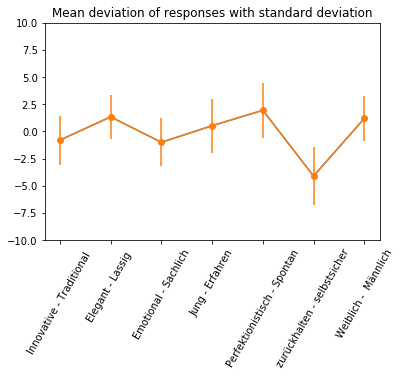

In [20]:
plt.plot(mean_input.mean())
plt.errorbar(range(len(mean_input.mean())), mean_input.mean(),yerr=std_input.mean(), fmt='-o')
plt.ylim(-10, 10)
plt.xticks(rotation=60)
plt.title("Mean deviation of responses with standard deviation")

## Correlation between input columns

In [25]:
corr1 = inputs[0].corr()
corr2 = inputs[1].corr()
corr3 = inputs[2].corr()

corr_total = inputs[0].append(inputs[1]).append(inputs[2]).corr()

Text(0.5, 1, 'Matt')

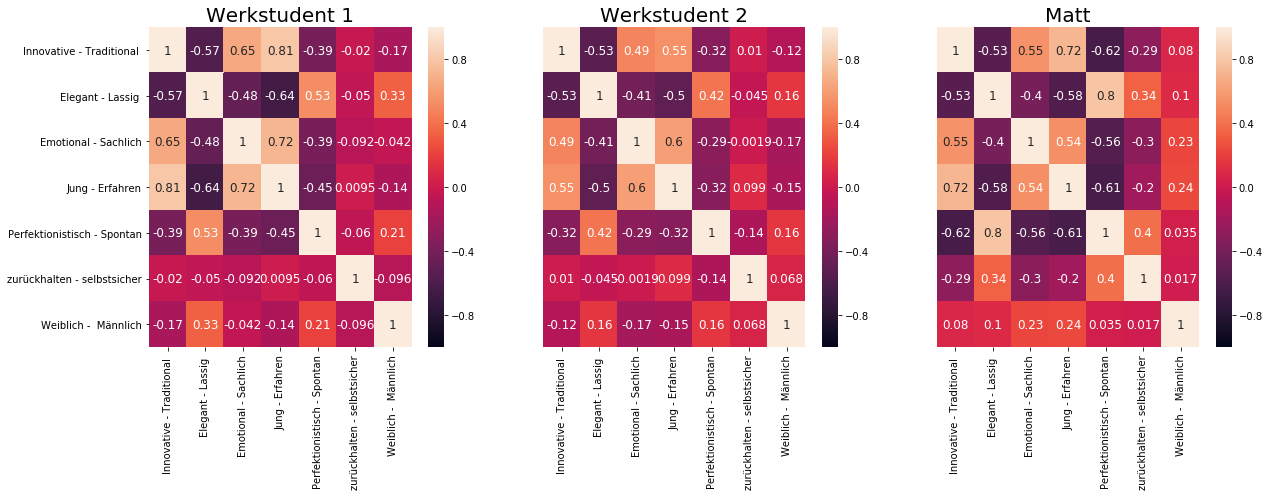

In [70]:
fig = plt.figure(figsize = (20, 20)) # width x height
ax1 = fig.add_subplot(331) # row, column, position
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)

sns.heatmap(corr1, ax=ax1, vmin=-1, vmax=1,  annot=True, annot_kws={'fontsize': 12}).set_title('Werkstudent 1', fontsize =20)
sns.heatmap(corr2, ax=ax2, vmin=-1, vmax=1,  yticklabels=False,  annot=True, annot_kws={'fontsize': 12}).set_title('Werkstudent 2', fontsize =20) 
sns.heatmap(corr3, ax=ax3, vmin=-1, vmax=1,  yticklabels=False, annot=True, annot_kws={'fontsize': 12}).set_title('Matt', fontsize =20) 

Text(0.5, 1, 'Combined correlation')

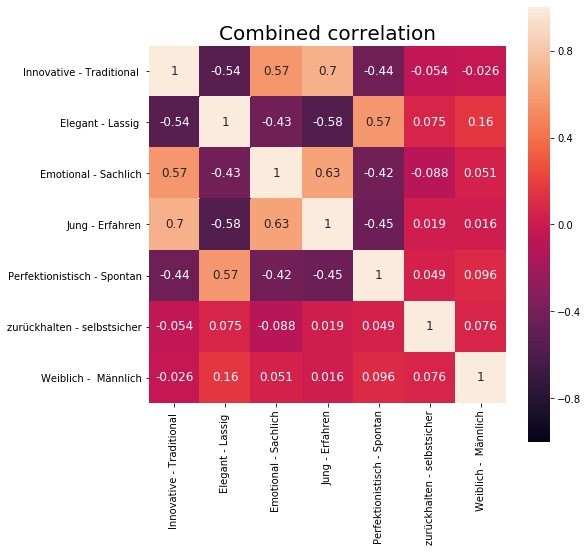

In [69]:
fig = plt.figure(figsize = (8, 8)) # width x height
ax1 = fig.add_subplot(111)  # row, column, position

sns.heatmap(corr_total, ax=ax1, vmin=-1, vmax=1, square=True, annot=True, annot_kws={'fontsize': 12}).set_title('Combined correlation', fontsize =20)